02で前処理をしたデータの読み込みと03で学習したモデルを使って推論を行うためのnotebookです。  

## 必要なライブラリのimport

In [46]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import pickle

In [76]:
# 予測したいデータの読み込み
path_test_preprp = '../../../../data/processed/test_processed_0619.csv'

test = pd.read_csv(path_test_preprp)
#del test['target']

## 保存されたモデルを使って予測を行う

In [100]:
n_folds = 5
predictions_cls = np.zeros(len(test))
features = [c for c in test.columns if c not in ['card_id',]]


for fold_ in range(n_folds):
    # モデルを読み込む
    with open(f'../src/models/lgb_11_cls/model_fold_{fold_}.pkl', 'rb') as f:
        clf = pickle.load(f)
    # モデルで予測を行う
    fold_predictions = clf.predict(test[features])
    # 予測結果を足し合わせる
    predictions_cls += fold_predictions

# 平均を取る
predictions_cls /= n_folds

# RMSEを計算する（テストデータに対して真の値がある場合）
# y_testが存在する場合に限り
if 'y_test' in locals():
    score = mean_squared_error(y_test, predictions_cls, squared=False)
    print(f'RMSE={score}')


In [101]:
print(len(predictions_cls[predictions_cls<0.7]))
print(predictions_cls.min())
predictions_cls = np.where(predictions_cls < 0.9, -33.21928095, 1)
# 予測結果を出力する
print(predictions_cls)

11
0.6666489979451958
[1. 1. 1. ... 1. 1. 1.]


In [79]:
tmp_cls = pd.DataFrame({"card_id":test["card_id"].values})
tmp_cls["target"] = predictions_cls
tmp_cls

,card_id,target
0,C_ID_0ab67a22ab,1.0
1,C_ID_130fd0cbdd,1.0
2,C_ID_b709037bc5,1.0
3,C_ID_d27d835a9f,1.0
4,C_ID_2b5e3df5c2,1.0
...,...,...
123618,C_ID_7a239d2eda,1.0
123619,C_ID_75ace375ae,1.0
123620,C_ID_21d56d950c,1.0
123621,C_ID_6c46fc5a9d,1.0


In [80]:
test_reg = test[test.card_id.isin(tmp_cls[tmp_cls.target==1].card_id)].reset_index(drop=True)

In [87]:
n_folds = 5
predictions = np.zeros(len(test_reg))
features = [c for c in test_reg.columns if c not in ['card_id',]]
#categorical_feats = ['feature_1','feature_2', 'feature_3','hist_merchant_category_nu','hist_merchant_category_mode','hist_city_nu','hist_city_mode','hist_state_nu','hist_state_mode','hist_category_1_mod','hist_category_2_mod','hist_category_3_mod','new_merchant_category_nu','new_merchant_category_mode','new_city_nu','new_city_mode','new_state_nu','new_state_mode','new_category_1_mod','new_category_2_mod','new_category_3_mod']


for fold_ in range(n_folds):
    # モデルを読み込む
    with open(f'../src/models/lgb_11_reg/model_fold_{fold_}.pkl', 'rb') as f:
        clf = pickle.load(f)
    # モデルで予測を行う
    fold_predictions = clf.predict(test_reg[features])
    # 予測結果を足し合わせる
    predictions += fold_predictions

# 平均を取る
predictions /= n_folds

# RMSEを計算する（テストデータに対して真の値がある場合）
# y_testが存在する場合に限り
if 'y_test' in locals():
    score = mean_squared_error(y_test, predictions, squared=False)
    print(f'RMSE={score}')

In [88]:
# 予測結果を出力する
print(predictions)

[-0.10077957  0.02924514  0.63447003 ...  0.94123341 -0.6613987
  0.26516787]


In [89]:
tmp_reg = pd.DataFrame({"card_id":test_reg["card_id"].values})
tmp_reg["target"] = predictions
tmp_reg
sub = pd.merge(tmp_cls,tmp_reg,how='left',on='card_id',suffixes=('_left', '_right'))
sub['target'] = sub['target_right'].combine_first(sub['target_left'])

# 不要な列を削除
sub= sub.drop(columns=['target_left', 'target_right'])
sub[sub.target  >0]

,card_id,target
1,C_ID_130fd0cbdd,0.029245
2,C_ID_b709037bc5,0.634470
5,C_ID_5814b4f13c,0.133874
6,C_ID_a1b3c75277,0.077434
7,C_ID_f7cada36d3,0.983535
...,...,...
123617,C_ID_0e74bd4966,0.213797
123618,C_ID_7a239d2eda,1.218686
123619,C_ID_75ace375ae,0.395518
123620,C_ID_21d56d950c,0.941233


In [90]:
sub

,card_id,target
0,C_ID_0ab67a22ab,-0.100780
1,C_ID_130fd0cbdd,0.029245
2,C_ID_b709037bc5,0.634470
3,C_ID_d27d835a9f,-0.119837
4,C_ID_2b5e3df5c2,-0.150017
...,...,...
123618,C_ID_7a239d2eda,1.218686
123619,C_ID_75ace375ae,0.395518
123620,C_ID_21d56d950c,0.941233
123621,C_ID_6c46fc5a9d,-0.661399


(array([1.1550e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

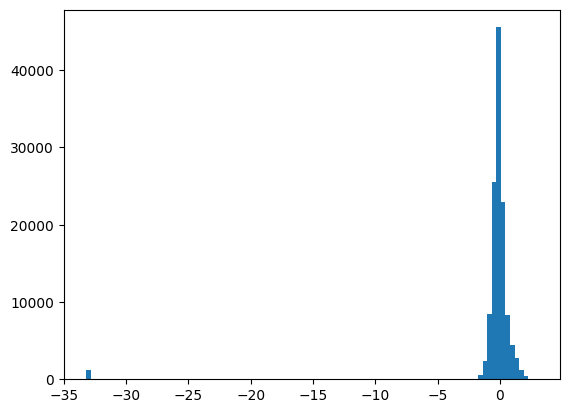

In [92]:
import matplotlib.pyplot as plt
plt.hist(sub.target,bins=100)

## 提出用ファイルの作成

In [93]:
sub.to_csv("../submit_oshikiri_0619_311.csv", index=False)